In [1]:
import numpy as np

Problem 1 Classification of fully connected layers

In [33]:
class GetMiniBatch:
    """
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [34]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        
        self.optimizer = optimizer
        self.W, self.B = initializer.W(n_nodes1, n_nodes2), initializer.B(n_nodes2)
        
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        A = X @ self.W + self.B
        
        return A
        
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """

        self.dB = np.mean(dA, axis = 0)
        self.dW = np.dot(self.X.T, dA)/len(self.X)
        
        dZ = dA @ self.W.T
        self = self.optimizer.update(self)
        
        return dZ

In [35]:


# initializer

class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
        
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        
        return B



Optimizer 

In [36]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr*layer.dW
        layer.B -= self.lr*layer.dB

        return layer

In [37]:
class activation_func:

    def __init__(self, function_type):
        
        self.function_type=function_type
        
    def forward(self, X):
        
        if self.function_type=="tanh":
            self.A = self.tanh_function(X)
        elif self.function_type=="softmax":
            self.A = self.softmax(X)

        return self.A
        
    def backward(self, dZ):

        if self.function_type=="tanh":
            grad_res = self.grad_tanh(dZ)
        elif self.function_type=="softmax":
            grad_res = self.grad_softmax(dZ)
        return grad_res

    def tanh_function(self, A):
        return (np.exp(A)-np.exp(-A))/(np.exp(A)+np.exp(-A))
    
    def softmax(self, A):
        return np.exp(A)/np.sum(np.exp(A), axis=0)

    def grad_tanh(self, dZ):
         return dZ * (1-self.A**2)

    def grad_softmax(self, dZ):
        return dZ

In [38]:
class ScratchSimpleDeepNeuralNetrowkClassifier():
    def __init__(self,
                 batch_size = 20, #number of data
                 n_features = 784, #input size
                 n_nodes1 = 400, # hidden size of first layer 
                 n_nodes2 = 200, # hidden size of second layer 
                 n_output = 10, # 0-9 total 10 numbers
                 sigma = 0.02, # parameter initialize 
                 lr = 0.01, #learning rate 
                 epoch = 10, #iteration 
                 verbose=True):
        
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2 
        self.n_output = n_output
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch
        self.loss_train = []
        self.loss_val = []

        #neural net initilize
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = activation_func(function_type='tanh')
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = activation_func(function_type='tanh')
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = activation_func(function_type='softmax')

    def fit(self, X, y, X_val=None, y_val=None):
        
        for e in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                self.Z3 = self.forward(mini_X_train)
                self.backward(mini_y_train)
                
            self.forward(X)
            self.loss_train.append(self.cross_entropy_error(y, self.Z3))
            
            if X_val is not None:
                self.forward(X_val)
                self.loss_val.append(self.cross_entropy_error(y_val, self.Z3))
                
            if self.verbose:
                if X_val is None:
                    print(self.loss_train)
                else:
                    print(f"Epoch {e}:", "Train loss:", self.loss_train[-1], "Val loss:", self.loss_val[-1])

    
    def forward(self, X):
        
        self.A1 = self.FC1.forward(X)
        self.Z1 = self.activation1.forward(self.A1)
        self.A2 = self.FC2.forward(self.Z1)
        self.Z2 = self.activation2.forward(self.A2)
        self.A3 = self.FC3.forward(self.Z2)
        self.Z3 = self.activation3.forward(self.A3)
        return self.Z3

    def backward(self, Y):

        self.dA3 = (self.Z3 - Y)/self.batch_size
        self.dZ2 = self.FC3.backward(self.dA3)
        self.dA2 = self.activation2.backward(self.dZ2)
        self.dZ1 = self.FC2.backward(self.dA2)
        self.dA1 = self.activation1.backward(self.dZ1)
        self.dZ0 = self.FC1.backward(self.dA1) #

    
    def cross_entropy_error(self, y, Z):
        L = - np.sum(y * np.log(Z+1e-7)) / len(y)
        return L
        
    def predict(self, X):
        self.forward(X)
        return np.argmax(self.Z3, axis=1)

Test

In [39]:
from sklearn.preprocessing import OneHotEncoder
import keras
from keras import layers
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [40]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train[:500, :] #because of computation
X_test = X_test[:100, :]
y_train = y_train[:500]
y_test = y_test[:100]

In [41]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [42]:
model_nn = ScratchSimpleDeepNeuralNetrowkClassifier(batch_size=8, epoch=50)

In [43]:
model_nn.fit(X_train, y_train_one_hot.toarray(), X_test, y_test_one_hot.toarray())

Epoch 0: Train loss: 6.2131157344382935 Val loss: 4.604782053226574
Epoch 1: Train loss: 6.209492644012882 Val loss: 4.601711520880262
Epoch 2: Train loss: 6.205865100553302 Val loss: 4.59863740593987
Epoch 3: Train loss: 6.202223648765309 Val loss: 4.59555138776255
Epoch 4: Train loss: 6.198558873588392 Val loss: 4.592445180032001
Epoch 5: Train loss: 6.194861354913943 Val loss: 4.589310490024265
Epoch 6: Train loss: 6.191121624152451 Val loss: 4.586138979443115
Epoch 7: Train loss: 6.187330122386882 Val loss: 4.582922226574155
Epoch 8: Train loss: 6.183477159909315 Val loss: 4.5796516895578545
Epoch 9: Train loss: 6.179552876997925 Val loss: 4.576318670632631
Epoch 10: Train loss: 6.175547205853035 Val loss: 4.57291428125096
Epoch 11: Train loss: 6.1714498336759664 Val loss: 4.569429408026059
Epoch 12: Train loss: 6.167250166944541 Val loss: 4.565854679525165
Epoch 13: Train loss: 6.162937297015685 Val loss: 4.562180433989449
Epoch 14: Train loss: 6.158499967270616 Val loss: 4.558396

In [46]:
from sklearn.metrics import accuracy_score, f1_score

In [47]:
pred = model_nn.predict(X_test)
print(pred)
acc = accuracy_score(y_test, pred)
print("Accuracy:", acc)

[7 0 1 0 4 1 9 9 2 9 0 0 9 0 1 0 7 7 3 4 9 6 6 6 4 0 7 4 0 1 3 1 3 0 7 2 7
 1 1 1 1 7 9 1 1 3 1 5 9 4 6 0 0 5 0 0 4 1 9 5 7 2 4 3 7 9 2 4 3 0 7 0 0 1
 1 9 3 7 1 7 9 6 2 7 1 9 7 3 6 1 3 6 8 3 1 2 8 1 6 9]
Accuracy: 0.66


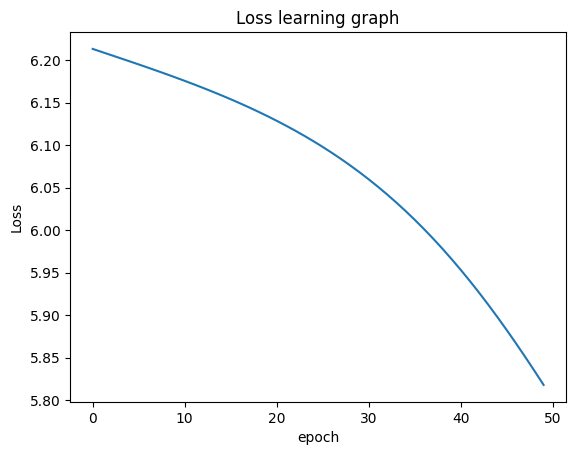

In [48]:
import matplotlib.pyplot as plt
fig = plt.subplots()
plt.title("Loss learning graph")
plt.xlabel("epoch")
plt.ylabel('Loss')
plt.plot(model_nn.loss_train)
plt.show()

In [49]:
class XavierInitializer:

    def __init__(self):
        self.n_prev_nodes = 1
        pass
        
    def W(self, n_nodes1, n_nodes2):
        self.n_prev_nodes = n_nodes1
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)
        return W
    
    def B(self, n_nodes2):
        B = np.random.randn(1, n_nodes2) / np.sqrt(self.n_prev_nodes)
        return B

In [50]:
class HeInitializer:
 
    def __init__(self):
        self.n_prev_nodes = 1
        pass
        
    def W(self, n_nodes1, n_nodes2):
        self.n_prev_nodes = n_nodes1
        W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
        return W
    
    def B(self, n_nodes2):
        B = np.random.randn(1, n_nodes2) * np.sqrt(2 / self.n_prev_nodes)
        return B

In [51]:
class AdaGrad:
  
    def __init__(self, lr):
        self.lr = lr
        self.H_B = 1
        self.H_W = 1
    def update(self, layer):
            
        #dA, dW Update & save
        self.H_B = self.H_B + np.average(layer.dA)**2
        self.H_W = self.H_W + np.average(layer.dW)**2
        
        layer.B = layer.B - self.lr * np.average(layer.dA, axis=0) / np.sqrt(self.H_B)
        layer.W = layer.W - self.lr * layer.dW / layer.dA.shape[0] / np.sqrt(self.H_W)
        
        return layer

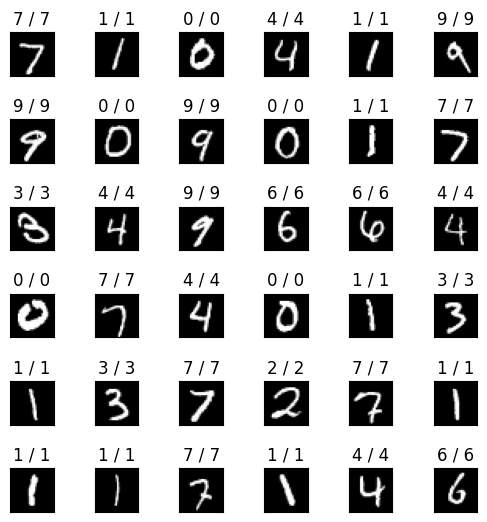

In [52]:
y_pred = model_nn.predict(x_test)

num = 36 #
true_false = y_pred == y_test
false_list = np.where(true_false==True)[0].astype(int)
x_test = x_test*255.0

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_test[false_list[i]]))
    ax.imshow(x_test.reshape(-1,28,28)[false_list[i]], cmap='gray')
plt.show()

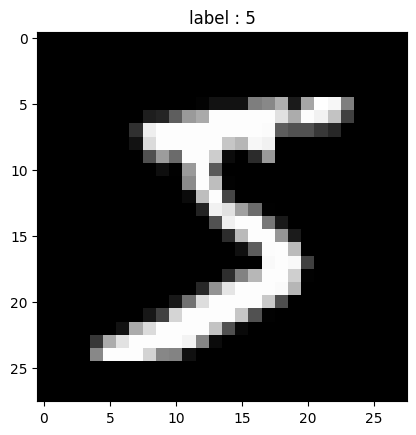

In [53]:
index = 0
image = x_train[index].reshape(28,28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

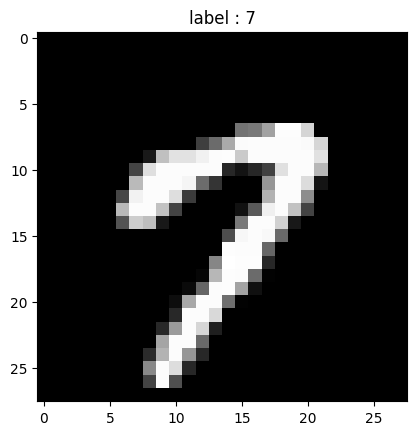

In [54]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
index = 15
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

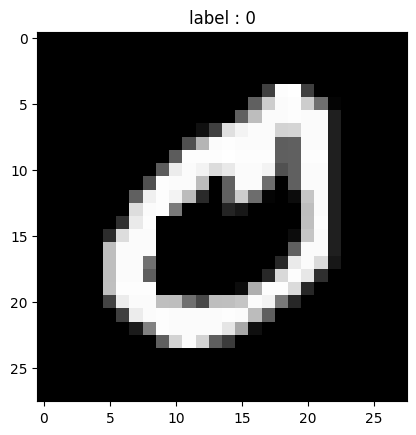

In [55]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
index = 21
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [70]:
import keras
from keras import layers
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [71]:
X_train[0].shape
X_train.shape
X_train = X_train.reshape((X_train.shape[0], 28*28)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28*28)).astype('float32')
X_train = X_train / 255
X_test = X_test / 255

In [72]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(32, input_dim = 28 * 28, activation= 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

In [80]:
model = ScratchSimpleDeepNeuralNetrowkClassifier(batch_size=8, epoch=50)

In [84]:
x_data = [[[(i+j)/100] for i in range (5)] for j in range(100)]
y_data = [(i+5)/100 for i in range (100)]
x_data = np.array(x_data, dtype=float)
y_data = np.array(y_data, dtype=float)

In [89]:
history = model.fit(X_train, y_train, epochs=1000, verbose=0)
y_predict = model.predict(X_test)
plt.scatter(range(20), y_predict, c='r')
plt.scatter(range(20), y_test, c='g')
plt.show()
plt.plot(history.history['loss'])
plt.show()


TypeError: ScratchSimpleDeepNeuralNetrowkClassifier.fit() got an unexpected keyword argument 'epochs'